# Listagem de artigos

**Fonte**: ASAA Journal

![ASAA Journal](img/asaa-journal-search.png)

**Bibliotecas importadas**

In [2]:
from time import sleep
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.support.select import Select

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from wordcloud import WordCloud, STOPWORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

options = Options()
options.binary_location = r'C:\Program Files (x86)\Mozilla Firefox\firefox.exe' # Localicação do programa firefox.exe

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UFT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
plt.style.use('seaborn')

In [5]:
url_search = 'https://asaa.anpcont.org.br/index.php/asaa/search'

In [4]:
def lista_links(driver):
    search_results = driver.find_element(By.CLASS_NAME, 'search_results')
    artigos = search_results.find_elements(By.TAG_NAME, 'a')
    links=[]
    for artigo in artigos:
        links.append(artigo.get_attribute('href'))
    return links

In [11]:
def captura_links(driver, url_search, palavra_chave, ano=2010):
    driver.get(url_search)
    input_search_xp = '//*[@id="query"]'
    select_year_xp = '//*[@id="dateFromYear"]'
    btn_search_xp = '/html/body/div/div[1]/div[1]/div/form/div[2]/button'
    driver.find_element(By.XPATH, input_search_xp).send_keys(palavra_chave)
    select_element = driver.find_element(By.XPATH, select_year_xp)
    select_object = Select(select_element)
    select_object.select_by_value(str(ano))
    driver.find_element(By.XPATH, btn_search_xp).click()
    sleep(1)
    url = driver.current_url
    links = lista_links(driver)
    try:
        pagination = driver.find_element(By.CLASS_NAME, 'cmp_pagination')
        next_page = pagination.find_elements(By.TAG_NAME, 'a')[-2]
        next_page_text = next_page.text
        while next_page_text == '>':
            next_page.click()
            sleep(2)
            links += lista_links(driver)
            pagination = driver.find_element(By.CLASS_NAME, 'cmp_pagination')
            next_page = pagination.find_elements(By.TAG_NAME, 'a')[-2]
            next_page_text = next_page.text
    except:
        pass
    return links

In [15]:
driver = webdriver.Firefox(executable_path='../webdrivers/geckodriver.exe', options=options)

links = captura_links(driver, url_search, 'contabilidade ambiental', 2010)

driver.close()

links

C:\Users\UFT\AppData\Local\Temp\ipykernel_5628\1787617041.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='../webdrivers/geckodriver.exe', options=options)


['https://asaa.anpcont.org.br/index.php/asaa/article/view/500',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/590',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/508',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/569',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/627',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/415',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/92',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/632',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/410',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/528',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/426',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/636',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/698',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/838',
 'https://asaa.anpcont.org.br/index.php/asaa/article/view/684',
 'https://asaa.anpcont.org.br/index.php/a

In [16]:
def limpa_string(string):
    string = string.replace('\t', '').replace('\n', '')
    if string[-1] == '.':
        string = string[:-1]
    return string

In [17]:
def captura_titulo(soup):
    try:
        h1_title = soup.find('h1', {'class': 'page_title'})
        titulo = limpa_string(h1_title.text)
    except:
        titulo = ''
    return titulo

In [18]:
def captura_autores(soup):
    try:
        section_authors = soup.find('section', {'class': 'item authors'})
        lista_autores = section_authors.find_all('li')
        qtd_autores = len(lista_autores)
        resultado = [qtd_autores]
        for autor in lista_autores:
            try:
                nome = autor.find('span', {'class': 'name'}).text
                nome = limpa_string(nome)
                afiliacao = autor.find('span', {'class': 'affiliation'}).text
                afiliacao = limpa_string(afiliacao)
            except:
                nome = ''
                afiliação = ''
            resultado.append(nome)
            resultado.append(afiliacao)
        for i in range(6 - qtd_autores):
            resultado.append('')
            resultado.append('')
    except:
        resultado = ['' for i in range(13)]
    return resultado

In [20]:
def captura_keywords(soup):
    try:
        section_keywords = soup.find('section', {'class': 'item keywords'})
        keywords = section_keywords.text
        keywords = limpa_string(keywords)
        keywords = keywords.replace('Keywords:', '')
        keywords = keywords.replace('.', ',')
    except:
        keywords = ''
    return keywords

In [21]:
def captura_resumo(soup):
    try:
        section_abstract = soup.find('section', {'class': 'item abstract'})
        abstract = section_abstract.text
        abstract = limpa_string(abstract)
        abstract = abstract.replace('Abstract', '')
    except:
        abstract = ''
    return abstract.strip()

In [23]:
def captura_data(soup):
    try:
        div_published = soup.find('div', {'class': 'item published'})
        data = div_published.text
        data = limpa_string(data)
        data = data.replace('Published', '')
    except:
        data = ''
    return data.strip()

In [24]:
def captura_artigo(url_artigo):
    page = requests.get(url_artigo)
    soup = BeautifulSoup(page.text, 'html.parser')
    data = captura_data(soup)
    titulo = captura_titulo(soup)
    palavras_chave = captura_keywords(soup)
    resumo = captura_resumo(soup)
    autores = captura_autores(soup)
    dados_artigo = [data, titulo, palavras_chave, resumo]
    dados_artigo += autores
    dados_artigo.append(url_artigo)
    return dados_artigo

In [25]:
revista = {
    'nome': 'Advances in Scientific and Applied Accounting – ASAA',
    'url busca': 'https://asaa.anpcont.org.br/index.php/asaa/search'
}
revista

{'nome': 'Advances in Scientific and Applied Accounting – ASAA',
 'url busca': 'https://asaa.anpcont.org.br/index.php/asaa/search'}

In [26]:
def captura_artigos(driver, revista, palavra_busca, ano=2010):
    nome = revista['nome']
    url_search = revista['url busca']
    urls_artigos = captura_links(driver, url_search, palavra_busca, ano)
    colnames = [
        'Data Publicação', 'Título', 'Palavras-chave', 'Resumo', 'Qtd. Autores',
        'Autor1 Nome', 'Autor1 Afiliação', 'Autor2 Nome', 'Autor2 Afiliação',
        'Autor3 Nome', 'Autor3 Afiliação', 'Autor4 Nome', 'Autor4 Afiliação',
        'Autor5 Nome', 'Autor5 Afiliação', 'Autor6 Nome', 'Autor6 Afiliação',
        'Url Artigo', 'Revista'
    ]
    lista_artigos = []
    for url_artigo in urls_artigos:
        try:
            dados_artigo = captura_artigo(url_artigo)
            dados_artigo.append(nome)
            lista_artigos.append(dados_artigo)
        except:
            pass
    artigos_df = pd.DataFrame(lista_artigos, columns=colnames)
    return artigos_df

In [30]:
def captura_todos_artigos(revista, chaves_de_pesquisa):
    artigos_df = pd.DataFrame()
    driver = webdriver.Firefox(executable_path='../webdrivers/geckodriver.exe', options=options)

    for palavra_busca in chaves_de_pesquisa:
        df = captura_artigos(driver, revista, palavra_busca, ano=2010)#captura_artigos_anpcont(chave_de_pesquisa)
        artigos_df = pd.concat([artigos_df, df])
    driver.close()
    artigos_df.reset_index(inplace=True)
    artigos_df = artigos_df.drop_duplicates(subset='Título')
    artigos_df['Data Publicação'] = pd.to_datetime(artigos_df['Data Publicação'], format='%d/%m/%Y')
    artigos_df = artigos_df.drop(['index'], axis=1)
    return artigos_df

In [31]:
chaves_de_pesquisa = ['contabilidade ambiental', 'balanço social']

In [32]:
artigos_df = captura_todos_artigos(revista, chaves_de_pesquisa)

C:\Users\UFT\AppData\Local\Temp\ipykernel_5628\1267877337.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='../webdrivers/geckodriver.exe', options=options)


In [33]:
artigos_df

,Data Publicação,Título,Palavras-chave,Resumo,Qtd. Autores,Autor1 Nome,Autor1 Afiliação,Autor2 Nome,Autor2 Afiliação,Autor3 Nome,Autor3 Afiliação,Autor4 Nome,Autor4 Afiliação,Autor5 Nome,Autor5 Afiliação,Autor6 Nome,Autor6 Afiliação,Url Artigo,Revista
0,2019-11-18,"RESPONSABILIDADE AMBIENTAL, CUSTO DE CAPITAL, ...","Certificação, Sinalização, Custo de capital, R...",O presente estudo teve por objetivo verificar ...,4,Jessica Prado Martins,Fucape Business School,Danilo Soares Monte-mor,Fucape Business School,Silvania Neris Nossa,Fucape Business School,Valcemiro Nossa,Fucape Business School,,,,,https://asaa.anpcont.org.br/index.php/asaa/art...,Advances in Scientific and Applied Accounting ...
1,2020-08-31,DESPESAS DE EXERCÍCIOS ANTERIORES: UMA ANÁLISE...,"Despesas de Exercícios Anteriores, Planejament...",O registro contábil de Despesas de Exercícios ...,2,Saulo Silva Lima Filho,Universidade Federal do Paraná,Blênio Cezar Severo Peixe,Universidade Federal do Paraná\rDepartamento d...,,,,,,,,,https://asaa.anpcont.org.br/index.php/asaa/art...,Advances in Scientific and Applied Accounting ...
2,2020-01-23,A CERTIFICAÇÃO ISO 14001 E O ENDIVIDAMENTO DAS...,"Certificação, ISO 14001, Endividamento, B3, Co...",A certificação ISO 14001 compreende um conjunt...,4,Enezio Mariano da Costa,Fucape Business School,Valcemiro Nossa,Fucape Business School,Silvania Neris Nossa,Fucape Business School,Vania Maria da Costa Borgerth,Fucape Business School,,,,,https://asaa.anpcont.org.br/index.php/asaa/art...,Advances in Scientific and Applied Accounting ...
3,2019-11-18,A INFLUÊNCIA DA ESTRUTURAÇÃO NA RELAÇÃO ENTRE ...,"Sistemas de Controle Gerencial, Alavancas de C...",O tema da pesquisa versa sobre a estruturação ...,4,Ivan Rafael Defaveri,Universidade Estadual do Oeste do Paraná,Delci Grapegia Dal Vesco,Universidade Estadual do Oeste do Paraná,Carlos Alberto Diehl,Universidade Vale do Rio dos Sinos,Leandro Augusto Toigo,Universidade Estadual do Oeste do Paraná,,,,,https://asaa.anpcont.org.br/index.php/asaa/art...,Advances in Scientific and Applied Accounting ...
4,2020-04-22,CUSTOS DA QUALIDADE EM HOSPITAIS ACREDITADOS,"Custos da qualidade, Custos de controle, Custo...",Esse estudo tem como objetivo identificar como...,4,Katia Abbas,Universidade Estadual de Maringá,Paulo Henrique Rezende da Silva,Possui graduação em Ciências Contábeis pela Un...,Marcia Maria Dos Santos Bortolocci Espejo,Universidade Federal do Mato Grosso do SUL (UFMS),Leticia Matiolli Grejo,Universidade Estadual do Paraná (UNESPAR - Apu...,,,,,https://asaa.anpcont.org.br/index.php/asaa/art...,Advances in Scientific and Applied Accounting ...
5,2019-07-23,CARACTERÍSTICAS INSTITUCIONAIS DOS PAÍSES E PR...,"Passivos Ambientais, Provisões Ambientais, Pas...",Esta pesquisa objetiva investigar a relação en...,3,Thiago Alberto dos Reis Prado,Universidade Federal de Uberlândia,Maísa de Souza Ribeiro,Universidade de São Paulo - FEA-RP USP,Marcelo Botelho de Moraes,USP - RP - Universidade de São Paulo - Ribeirã...,,,,,,,https://asaa.anpcont.org.br/index.php/asaa/art...,Advances in Scientific and Applied Accounting ...
6,2013-12-18,Measurement of environmental benefits and impa...,"Environmental balance sheet, Environmental acc...",This paper aims to develop a conceptual framew...,3,Amaury José Rezende,FEA-RP/USP,Maisa de Sousa Ribeiro,FEA-RP/USP,Silvio Hiroshi Nakao,FEA-RP/USP,,,,,,,https://asaa.anpcont.org.br/index.php/asaa/art...,Advances in Scientific and Applied Accounting ...
7,2020-04-22,PARTICIPAÇÃO E CONSTITUIÇÃO DE RESERVAS ORÇAME...,"Participação orçamentária, Incerteza ambiental...",Este estudo tem como objetivo verificar em que...,3,Danrlei Anderson Peyerl,Universidade Regional de Blumenau,Franciele Beck,Universidade Regional de Blumenau,Daniel Magalhães Mucci,Universidade de São Paulo,,,,,,,https://asaa.anpcont.org.br/index.php/asaa/art...,Advances in Scientific and Applied Accounting ...
8,2019-11-18,A PRECARIEDADE DO CONTEÚDO INFORMACIONAL DOS A...,"Riscos Fiscais, Lei de Res

In [34]:
artigos_df.to_csv('data/asaa_anpcont.csv', index=False)

In [35]:
artigos_df['Qtd. Autores'].describe()

count    23.000000
mean      2.739130
std       1.009833
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       4.000000
Name: Qtd. Autores, dtype: float64

In [36]:
lista = []
for i in range(1, 7):
    lista += artigos_df[f'Autor{i} Afiliação'].to_list()
lista = [_ for _ in lista if _ != '']

afiliacao = pd.DataFrame(lista, columns=['Afiliação'])
afiliacao_count = afiliacao.value_counts()[:10].reset_index().rename(columns={0:'Count'})

In [37]:
afiliacao_count

,Afiliação,Count
0,Fucape Business School,12
1,Universidade Federal de Uberlândia,6
2,Universidade de São Paulo,5
3,FEA-RP/USP,3
4,Universidade Federal de Pernambuco,3
5,Universidade Estadual do Oeste do Paraná,3
6,Universidade Regional de Blumenau,3
7,Universidade Federal de Uberlândia - UFU,3
8,Universidade Federal do Paraná,3
9,Universidade Federal de Viçosa,2


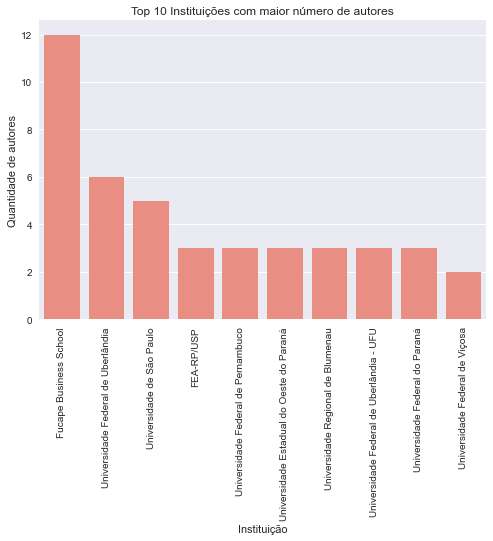

In [38]:
ax = sns.barplot(x='Afiliação', y='Count', data=afiliacao_count, color='salmon')
ax.set_xlabel('Instituição')
ax.set_ylabel('Quantidade de autores')
ax.set_title('Top 10 Instituições com maior número de autores')
plt.xticks(rotation=90)
plt.show()

In [39]:
palavras_chave = []
for item in artigos_df['Palavras-chave'].to_list():
    aux = item.split('.')
    palavras_chave += [_ for _ in aux if _ != '']

    
palavras_df = pd.DataFrame(palavras_chave, columns=['Palavras'])
palavras_count = palavras_df.value_counts()[:10].reset_index().rename(columns={0:'Count'})
palavras_count

,Palavras,Count
0,"Assimetria de custos, Gerenciamento de resulta...",1
1,"Book-Tax Differences, Governança Corporativa, ...",1
2,"Sistemas de Controle Gerencial, Sistemas de Co...",1
3,"Sistemas de Controle Gerencial, Alavancas de c...",1
4,"Sistemas de Controle Gerencial, Alavancas de C...",1
5,"Riscos Fiscais, Lei de Responsabilidade Fiscal...",1
6,"Passivos Ambientais, Provisões Ambientais, Pas...",1
7,"Participação orçamentária, Incerteza ambiental...",1
8,"Municípios, Contabilidade Aplicada ao Setor Pú...",1
9,"Legitimidade Normativa, Informação Contábil, S...",1


In [40]:
comment_words = ''
stopwords = set(stopwords.words('portuguese'))

In [41]:
for val in artigos_df['Palavras-chave']:
    val = str(val.replace('.', ''))
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()  
    comment_words += " ".join(tokens)+" "

In [42]:
wordcloud = WordCloud(width = 1000, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

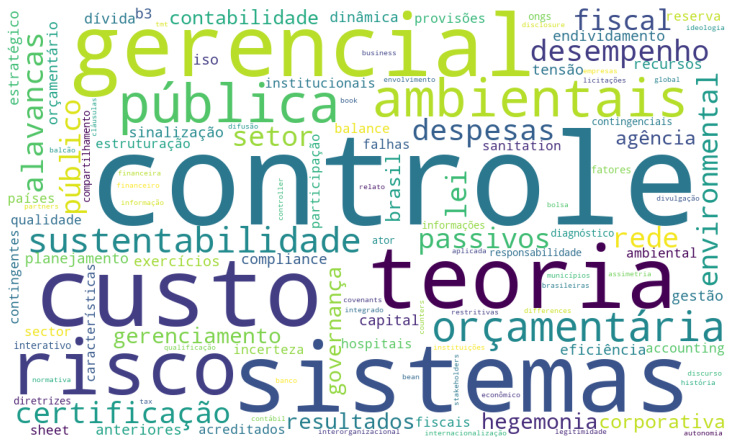

In [43]:
# plot the WordCloud image                      
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [44]:
artigos_ano = artigos_df['Data Publicação'].groupby([artigos_df['Data Publicação'].dt.year]).agg('count')

In [45]:
artigos_ano

Data Publicação
2013     1
2018     1
2019     6
2020    14
2021     1
Name: Data Publicação, dtype: int64

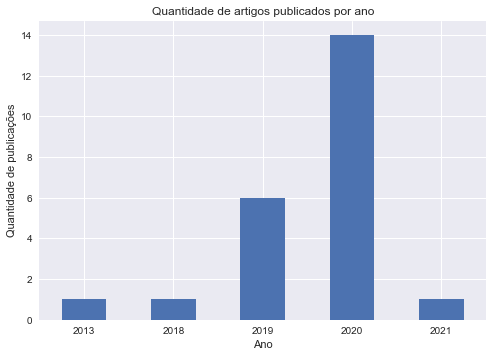

In [46]:
ax = artigos_ano.plot.bar()
ax.set_xlabel('Ano')
ax.set_ylabel('Quantidade de publicações')
ax.set_title('Quantidade de artigos publicados por ano')
plt.xticks(rotation=0)

plt.show()

In [3]:
def captura_artigos_anpcont(palavra_chave, ano=2010):
    url = 'https://asaa.anpcont.org.br/index.php/asaa/search'
    driver = webdriver.Firefox(executable_path='../webdrivers/geckodriver.exe', options=options)
    driver.get(url)
    input_search_xp = '//*[@id="query"]'
    btn_search_xp = '/html/body/div/div[1]/div[1]/div/form/div[2]/button'
    select_year_xp = '//*[@id="dateFromYear"]'
    driver.find_element(By.XPATH, input_search_xp).send_keys(palavra_chave)
    select_element = driver.find_element(By.XPATH, select_year_xp)
    select_object = Select(select_element)
    select_object.select_by_value(str(ano))
    driver.find_element(By.XPATH, btn_search_xp).click()
    search_results = driver.find_element(By.CLASS_NAME, 'search_results')
    artigos = search_results.find_elements(By.TAG_NAME, 'li')
    list_data = lista_artigos(driver, artigos)
    col_names = ['Data', 'Título', 'Palavras-Chave', 'Resumo', 'Link', 'Qtd. Autores', 'Autor1.Nome', 'Autor1.Afiliação', 'Autor2.Nome', 'Autor2.Afiliação', 'Autor3.Nome', 'Autor3.Afiliação', 'Autor4.Nome', 'Autor4.Afiliação', 'Autor5.Nome', 'Autor5.Afiliação', 'Autor6.Nome', 'Autor6.Afiliação']
    df = pd.DataFrame(list_data, columns=col_names)
    driver.close()
    return df

In [4]:
def captura_autores(soup):
    lista_autores = []
    try:
        ul_authors = soup.find('ul', {'class': 'authors'})
        li_authors = ul_authors.find_all('li')
        qtd_autores = len(li_authors)
        for autor in li_authors:
            nome = autor.find('span', {'class': 'name'}).text.replace('\n', '').replace('\t', '')
            afiliacao = autor.find('span', {'class': 'affiliation'}).text.replace('\n', '').replace('\t', '')
            lista_autores.append(nome)
            lista_autores.append(afiliacao)
        if qtd_autores < 6:
            for i in range(6 - qtd_autores):
                lista_autores.append('')
                lista_autores.append('')
    except:
        for i in range(6):
            lista_autores.append('')
            lista_autores.append('')
    lista_autores = [qtd_autores] + lista_autores
    return lista_autores

In [5]:
def lista_artigos(driver, artigos):
    list_data = []
    for artigo in artigos:
        a = artigo.find_element(By.TAG_NAME, 'a')
        link = a.get_attribute('href')
        titulo = a.text.capitalize()
        #autores = artigo.find_element(By.CLASS_NAME, 'authors').text
        data = artigo.find_element(By.CLASS_NAME, 'published').text
        driver.execute_script("window.open('');")
        driver.switch_to.window(driver.window_handles[1])
        driver.get(link)
        sleep(2)

        html = driver.page_source
        soup = BeautifulSoup(html)
        kw = captura_keywords(soup)
        abstract = captura_abstract(soup)
        row = [data, titulo, kw, abstract, link]
        row += captura_autores(soup)
        list_data.append(row)
        driver.close()
        driver.switch_to.window(driver.window_handles[0])
    return list_data

In [6]:
def captura_keywords(soup):
    try:
        kw_section = soup.find('section', {'class': 'item keywords'})
        kw = kw_section.text.replace('Keywords:', '').replace('\n', '').replace('\t', '').replace(',', '.').lower()
    except:
        kw = ''
    return kw

In [7]:
def captura_abstract(soup):
    try:
        abstract_section = soup.find('section', {'class': 'item abstract'})
        abstract = abstract_section.text.replace('Abstract', '').replace('\n', '').replace('\t', '')
    except:
        abstract = ''
    return abstract

In [8]:
chaves_de_pesquisa = ['contabilidade ambiental', 'balanço social']

In [9]:
anpcont_df = pd.DataFrame()
for chave_de_pesquisa in chaves_de_pesquisa:
    df = captura_artigos_anpcont(chave_de_pesquisa)
    anpcont_df = pd.concat([anpcont_df, df])
anpcont_df.reset_index(inplace=True)
anpcont_df = anpcont_df.drop_duplicates(subset='Título')
anpcont_df['Data'] = pd.to_datetime(anpcont_df['Data'], format='%d/%m/%Y')
anpcont_df = anpcont_df.drop(['index'], axis=1)

C:\Users\UFT\AppData\Local\Temp\ipykernel_8184\3859316771.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='../webdrivers/geckodriver.exe', options=options)
C:\Users\UFT\AppData\Local\Temp\ipykernel_8184\3859316771.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path='../webdrivers/geckodriver.exe', options=options)


In [10]:
anpcont_df.head()

,Data,Título,Palavras-Chave,Resumo,Link,Qtd. Autores,Autor1.Nome,Autor1.Afiliação,Autor2.Nome,Autor2.Afiliação,Autor3.Nome,Autor3.Afiliação,Autor4.Nome,Autor4.Afiliação,Autor5.Nome,Autor5.Afiliação,Autor6.Nome,Autor6.Afiliação
0,2019-11-18,"Responsabilidade ambiental, custo de capital, ...",certificação. sinalização. custo de capital. r...,O presente estudo teve por objetivo verificar ...,https://asaa.anpcont.org.br/index.php/asaa/art...,4,Jessica Prado Martins,Fucape Business School,Danilo Soares Monte-mor,Fucape Business School,Silvania Neris Nossa,Fucape Business School,Valcemiro Nossa,Fucape Business School,,,,
1,2020-08-31,Despesas de exercícios anteriores: uma análise...,despesas de exercícios anteriores. planejament...,O registro contábil de Despesas de Exercícios ...,https://asaa.anpcont.org.br/index.php/asaa/art...,2,Saulo Silva Lima Filho,Universidade Federal do Paraná,Blênio Cezar Severo Peixe,Universidade Federal do ParanáDepartamento de ...,,,,,,,,
2,2020-01-23,A certificação iso 14001 e o endividamento das...,certificação. iso 14001. endividamento. b3. co...,A certificação ISO 14001 compreende um conjunt...,https://asaa.anpcont.org.br/index.php/asaa/art...,4,Enezio Mariano da Costa,Fucape Business School,Valcemiro Nossa,Fucape Business School,Silvania Neris Nossa,Fucape Business School,Vania Maria da Costa Borgerth,Fucape Business School,,,,
3,2019-11-18,A influência da estruturação na relação entre ...,sistemas de controle gerencial. alavancas de c...,O tema da pesquisa versa sobre a estruturação ...,https://asaa.anpcont.org.br/index.php/asaa/art...,4,Ivan Rafael Defaveri,Universidade Estadual do Oeste do Paraná,Delci Grapegia Dal Vesco,Universidade Estadual do Oeste do Paraná,Carlos Alberto Diehl,Universidade Vale do Rio dos Sinos,Leandro Augusto Toigo,Universidade Estadual do Oeste do Paraná,,,,
4,2020-04-22,Custos da qualidade em hospitais acreditados,custos da qualidade. custos de controle. custo...,Esse estudo tem como objetivo identificar como...,https://asaa.anpcont.org.br/index.php/asaa/art...,4,Katia Abbas,Universidade Estadual de Maringá,Paulo Henrique Rezende da Silva,Possui graduação em Ciências Contábeis pela Un...,Marcia Maria Dos Santos Bortolocci Espejo,Universidade Federal do Mato Grosso do SUL (UFMS),Leticia Matiolli Grejo,Universidade Estadual do Paraná (UNESPAR - Apu...,,,,


In [11]:
anpcont_df['Qtd. Autores'].describe()

count    23.000000
mean      2.739130
std       1.009833
min       1.000000
25%       2.000000
50%       3.000000
75%       4.000000
max       4.000000
Name: Qtd. Autores, dtype: float64

In [12]:
lista = []
for i in range(1, 7):
    lista += anpcont_df[f'Autor{i}.Afiliação'].to_list()
lista = [_ for _ in lista if _ != '']

afiliacao = pd.DataFrame(lista, columns=['Afiliação'])
afiliacao_count = afiliacao.value_counts()[:10].reset_index().rename(columns={0:'Count'})

In [13]:
afiliacao_count

,Afiliação,Count
0,Fucape Business School,12
1,Universidade Federal de Uberlândia,6
2,Universidade de São Paulo,5
3,FEA-RP/USP,3
4,Universidade Federal de Pernambuco,3
5,Universidade Federal do Paraná,3
6,Universidade Federal de Uberlândia - UFU,3
7,Universidade Regional de Blumenau,3
8,Universidade Estadual do Oeste do Paraná,3
9,Universidade Federal de Viçosa,2


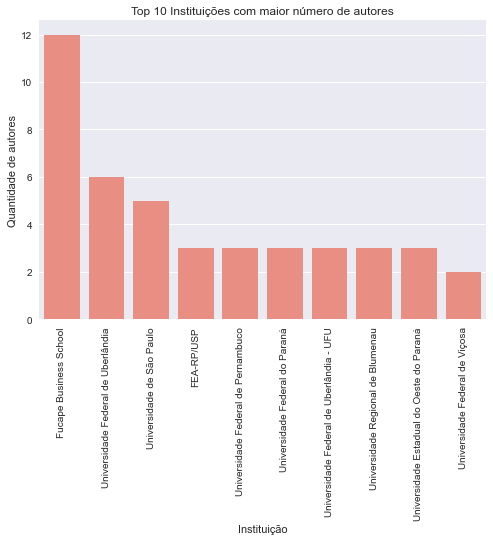

In [14]:
ax = sns.barplot(x='Afiliação', y='Count', data=afiliacao_count, color='salmon')
ax.set_xlabel('Instituição')
ax.set_ylabel('Quantidade de autores')
ax.set_title('Top 10 Instituições com maior número de autores')
plt.xticks(rotation=90)
plt.show()

In [15]:
palavras_chave = []
for item in anpcont_df['Palavras-Chave'].to_list():
    aux = item.split('.')
    palavras_chave += [_ for _ in aux if _ != '']

    
palavras_df = pd.DataFrame(palavras_chave, columns=['Palavras'])
palavras_count = palavras_df.value_counts()[:10].reset_index().rename(columns={0:'Count'})
palavras_count

,Palavras,Count
0,sistemas de controle gerencial,3
1,gerenciamento de resultados,2
2,certificação,2
3,sustentabilidade,2
4,hegemonia,2
5,governança corporativa,2
6,alavancas de controle,2
7,brasil,1
8,sistemas de controle interativo,1
9,teoria da estruturação,1


In [16]:
comment_words = ''
stopwords = set(stopwords.words('portuguese'))

In [17]:
for val in anpcont_df['Palavras-Chave']:
    val = str(val.replace('.', ''))
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()  
    comment_words += " ".join(tokens)+" "

In [18]:
wordcloud = WordCloud(width = 1000, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

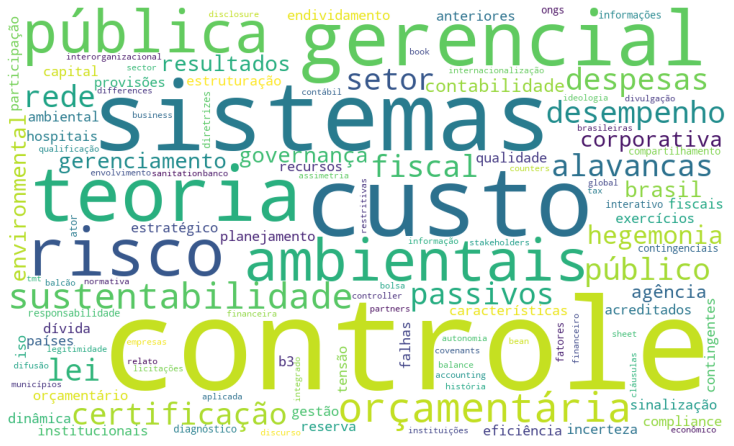

In [19]:
# plot the WordCloud image                      
plt.figure(figsize = (10, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [24]:
artigos_ano = anpcont_df['Data'].groupby([anpcont_df['Data'].dt.year]).agg('count')

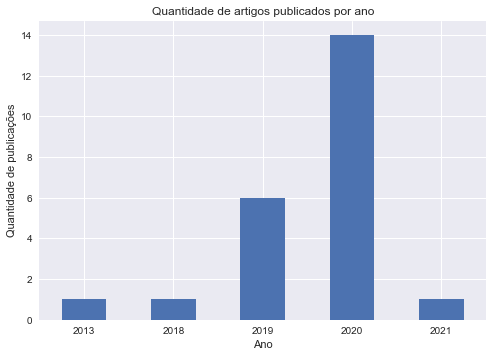

In [36]:
ax = artigos_ano.plot.bar()
ax.set_xlabel('Ano')
ax.set_ylabel('Quantidade de publicações')
ax.set_title('Quantidade de artigos publicados por ano')
plt.xticks(rotation=0)

plt.show()